Paper Source

"Step-by-Step HHL Algorithm Walkthrough to Enhance the Understanding of Critical Quantum Computing Concepts"

https://arxiv.org/abs/2108.09004

<b>To cite</b>

Hector Morrell and Hiu Yung Wong, "Step-by-Step HHL Algorithm Walkthrough to Enhance the Understanding of Critical Quantum Computing Concepts", arXiv preprint arXiv:2108.09004


In [128]:
from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit.compiler import transpile
from qiskit.visualization import *
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.visualization import plot_histogram
import numpy as np
from copy import deepcopy
from matplotlib import pyplot as plt

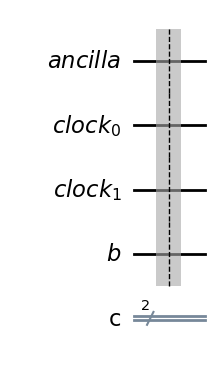

In [129]:
# Create the various registers needed
clock = QuantumRegister(2, name='clock')
input = QuantumRegister(1, name='b')
ancilla = QuantumRegister(1, name='ancilla')
measurement = ClassicalRegister(2, name='c')

# Create an empty circuit with the specified registers
circuit = QuantumCircuit(ancilla, clock, input, measurement)

circuit.barrier()
circuit.draw(output='mpl')

In [130]:
def qft_dagger(circ, q, n):      
    circ.h(clock[1]);
    for j in reversed(range(n)):
      for k in reversed(range(j+1,n)):
        circ.cp(-np.pi/float(2**(k-j)), q[k], q[j]) ;
    circ.h(clock[1]);

def qft(circ, q, n):      
    circ.h(clock[1]);
    for j in range(n):
      for k in range(j+1,n):
        circ.cp(np.pi/float(2**(k-j)), q[k], q[j]) ;
    circ.h(clock[1]);

In [131]:
def qpe(circ, clock, target):
    circuit.barrier()

    # e^{i*A*t}
    circuit.cu(np.pi/2, -np.pi/2, np.pi/2, 3*np.pi/4, clock[0], input, label='U');
    
    # e^{i*A*t*2}
    circuit.cu(np.pi, np.pi, 0, 0, clock[1], input, label='U2');

    circuit.barrier();
    
    # Perform an inverse QFT on the register holding the eigenvalues
    qft_dagger(circuit, clock, 2)
    
def inv_qpe(circ, clock, target):
    
    # Perform a QFT on the register holding the eigenvalues
    qft(circuit, clock, 2)

    circuit.barrier()

    # e^{i*A*t*2}
    circuit.cu(np.pi, np.pi, 0, 0, clock[1], input, label='U2');

    #circuit.barrier();

    # e^{i*A*t}
    circuit.cu(np.pi/2, np.pi/2, -np.pi/2, -3*np.pi/4, clock[0], input, label='U');

    circuit.barrier()

In [132]:
def hhl(circ, ancilla, clock, input, measurement):
    
    qpe(circ, clock, input)

    circuit.barrier()
    
    # This section is to test and implement C = 1
    circuit.cry(np.pi, clock[0], ancilla)
    circuit.cry(np.pi/3, clock[1], ancilla)

    circuit.barrier()
    
    circuit.measure(ancilla, measurement[0])
    circuit.barrier()
    inv_qpe(circ, clock, input)

In [133]:
# State preparation.
initial_state = [0, 1]
circuit.initialize(initial_state, input[0])  # 用 input[0] 更直观

circuit.barrier()

# Perform a Hadamard Transform
circuit.h(clock)

hhl(circuit, ancilla, clock, input, measurement)

# Perform a Hadamard Transform
circuit.h(clock)

circuit.barrier()

circuit.measure(input, measurement[1])

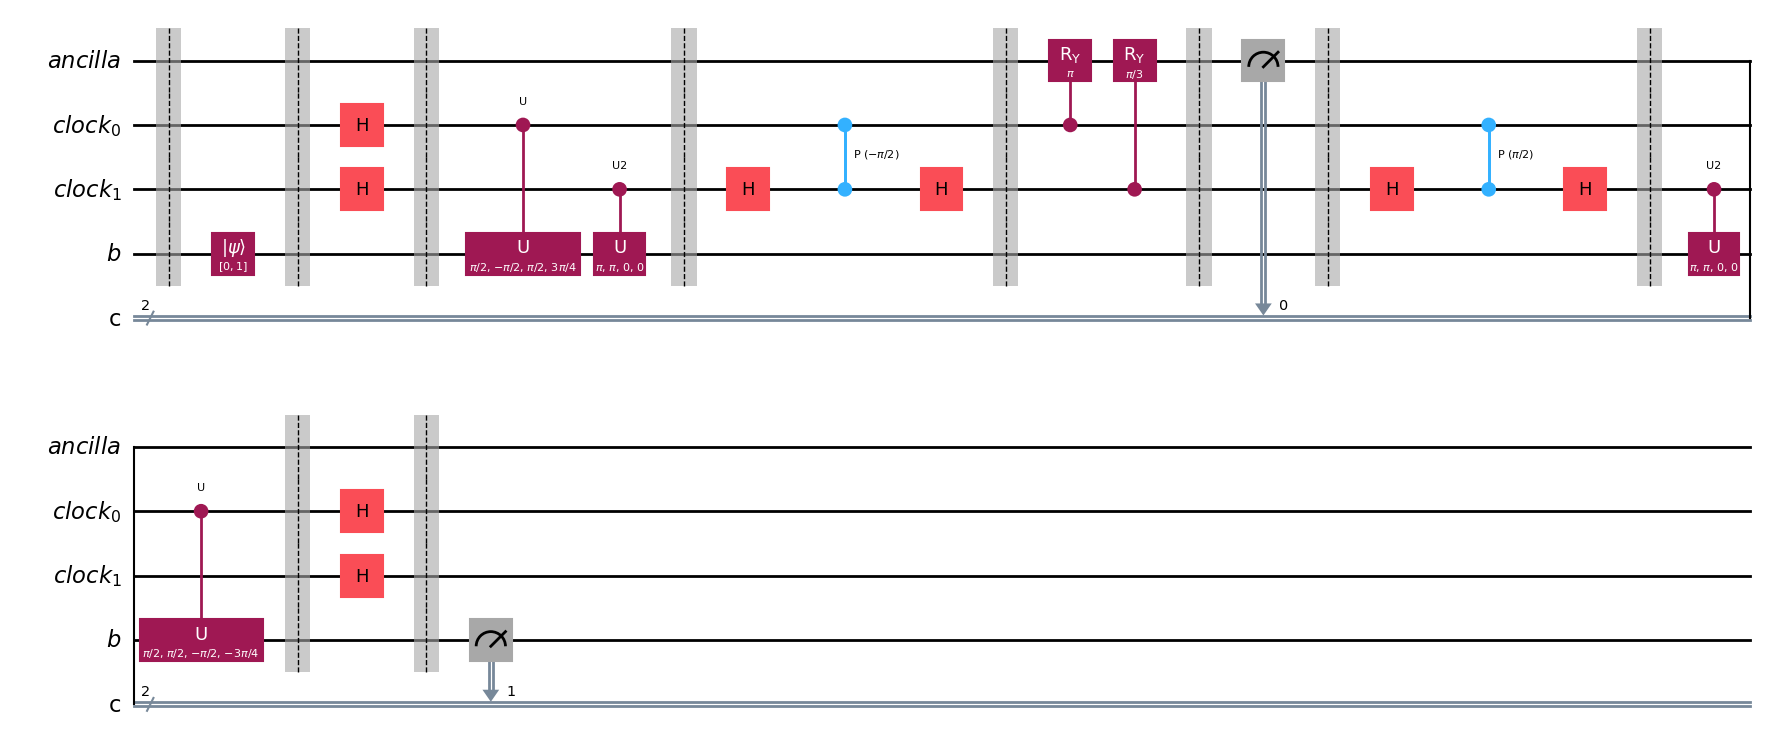

In [134]:
circuit.draw('mpl',scale=1)

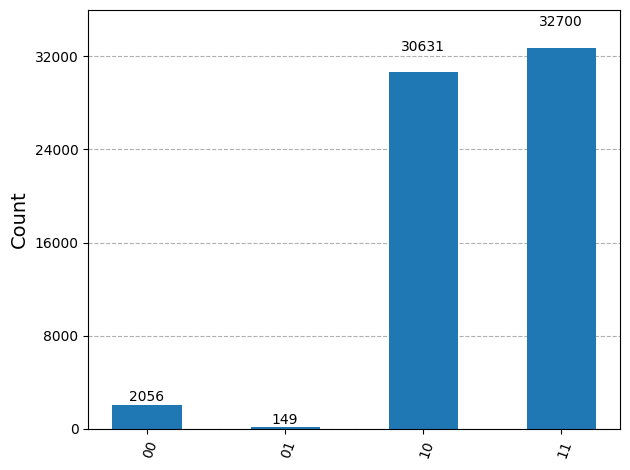

In [135]:
# 获取模拟器后端（新版写法）
simulator = Aer.get_backend('qasm_simulator')

# 直接通过后端的 run 方法执行电路（替代 execute）
job = simulator.run(circuit, shots=65536)

# 获取结果（保持不变）
result = job.result()

# 获取计数（保持不变）
counts = result.get_counts(circuit)

# 显示结果（保持不变）
plot_histogram(counts)

In [136]:
# 获取状态向量模拟器后端
bcknd = Aer.get_backend('statevector_simulator')

# 使用后端的 run() 方法替代 execute()
job_sim = bcknd.run(circuit)  # 移除 execute，直接用后端运行

# 获取结果
result = job_sim.result()

# 获取状态向量（保持不变）
o_state_result = result.get_statevector(circuit, decimals=3)
print(o_state_result)

Statevector([0.   -0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j, 0.   -0.j,
             0.   +0.j, 0.   +0.j, 0.   +0.j, 0.499-0.j, 0.   +0.j,
             0.864-0.j, 0.   +0.j, 0.049+0.j, 0.   +0.j, 0.049+0.j,
             0.   +0.j],
            dims=(2, 2, 2, 2))


In [137]:
from qiskit_aer import Aer

# 获取本地模拟器
backend = Aer.get_backend('qasm_simulator')

# 执行电路并直接获取结果
job_exp = backend.run(circuit, shots=8192)
result = job_exp.result()  # 本地执行几乎瞬间完成，直接等待结果

# 后续处理（如获取计数）
counts = result.get_counts()
print(counts)

{'01': 16, '00': 301, '10': 3873, '11': 4002}


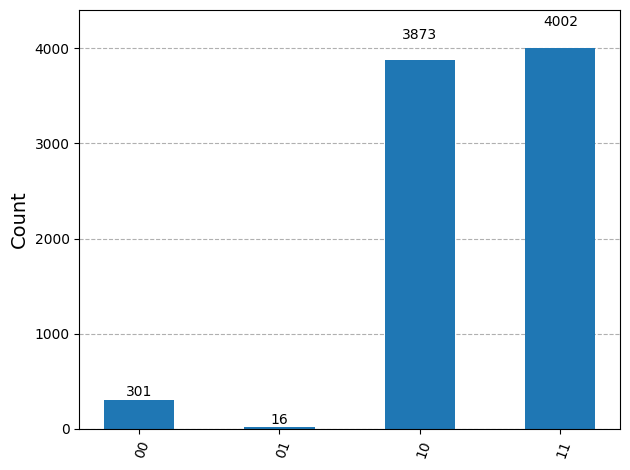

In [138]:
# Get the results from the computation
results = job_exp.result()

# Get the statistics
answer = results.get_counts(circuit)

# Plot the results
plot_histogram(answer)